# Post Hoc All in One Image Restoration for Novel View Synthesis

In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
from instructir.utils import *
import sys
sys.path.append('instructir')
from instructir.models import instructir
from instructir.text.models import LanguageModel, LMHead
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import yaml
from instructir.utils import *
from datasets import load_dataset
from instructir.text.models import LanguageModel, LMHead
from huggingface_hub import hf_hub_download 

SEED=42
seed_everything(SEED=SEED)
torch.backends.cudnn.deterministic = True

In [92]:
class InstructIR:

    def __init__(self, original=True):
        CONFIG     = "instructir/configs/eval5d.yml"
        LM_MODEL   = "instructir/models/lm_instructir-7d.pt"
        if original:
            MODEL_NAME = "instructir/models/im_instructir-7d.pt"
        else:
            MODEL_NAME = hf_hub_download(repo_id="Wouter01/InstructIR_re10k_hard", filename="best_model.pt")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        with open(os.path.join(CONFIG), "r") as f:
            config = yaml.safe_load(f) 
        cfg = dict2namespace(config)
        self.model = instructir.create_model(input_channels =cfg.model.in_ch, width=cfg.model.width, enc_blks = cfg.model.enc_blks, 
                            middle_blk_num = cfg.model.middle_blk_num, dec_blks = cfg.model.dec_blks, txtdim=cfg.model.textdim)
        self.model.load_state_dict(torch.load(MODEL_NAME, map_location=device), strict=True)
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        LMODEL = cfg.llm.model
        self.language_model = LanguageModel(model=LMODEL)
        self.lm_head = LMHead(embedding_dim=cfg.llm.model_dim, hidden_dim=cfg.llm.embd_dim, num_classes=cfg.llm.nclasses)
        self.lm_head = self.lm_head.to(device)
        self.lm_head.load_state_dict(torch.load(LM_MODEL, map_location=device), strict=True)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

    def run(self, image_path, iterations=1):
        image = load_img(image_path)
        y = torch.Tensor(image).permute(2,0,1).unsqueeze(0)

        # Get the text embedding (and predicted degradation class)
        lm_embd = self.language_model("Please make the image crispier and sharper")
        lm_embd = lm_embd #.to(device)
        text_embd, deg_pred = self.lm_head (lm_embd)

        # Forward pass: Paper Figure 2
        for _ in range(iterations):
            y = self.model(y, text_embd)

        # convert the restored image <x_hat> into a np array
        restored_img = y[0].permute(1,2,0).cpu().detach().numpy()
        restored_img = np.clip(restored_img, 0. , 1.)
        return image, restored_img


class ControlNet:
    
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def run(self, image_path, repo_name="Wouter01/diffusion_re10k_hard", checkpoint="210000"):
        d1 = hf_hub_download(repo_id=repo_name , subfolder=f"checkpoint-{checkpoint}/controlnet" , filename="diffusion_pytorch_model.safetensors") 
        d2 = hf_hub_download(repo_id=repo_name , subfolder=f"checkpoint-{checkpoint}/controlnet" , filename="config.json") 
        b = "/".join(d1.split("/")[:-1])

        # for checkpoint in self.checkpoints:
        controlnet = ControlNetModel.from_pretrained(b)  # "Wouter01/diffusion_re10k_hard"
        self.pipeline = StableDiffusionControlNetPipeline.from_pretrained(
            "stabilityai/stable-diffusion-2-1-base", controlnet=controlnet
        )
        self.pipeline.to(self.device)
        generator = torch.Generator(device=self.device)

        image = Image.open(image_path)
        diffused_image = self.pipeline(
            prompt="",
            image=image,
            generator=generator,
            width=256,
            height = 256, # height=height, # FIXME both width and height must be divisible by 8, but 180 isn't
            strength=1.0,
            guidance_scale=7.5,  # less emphasis on text prompt? just a guess
            controlnet_conditioning_scale=1.0,  # higher emphasis on the conditioning image? just a guess. setting it to higher than 1.0 produced garbage
            num_inference_steps=25
        ).images[0]

        return image, diffused_image

In [88]:
def get_original_instructIR_model():
    return InstructIR(original=True)

def get_finetuned_instructIR_model():
    return InstructIR(original=False)

def get_controlnet_model():
    return ControlNet()

/home/wouter/miniconda3/envs/dl2023/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


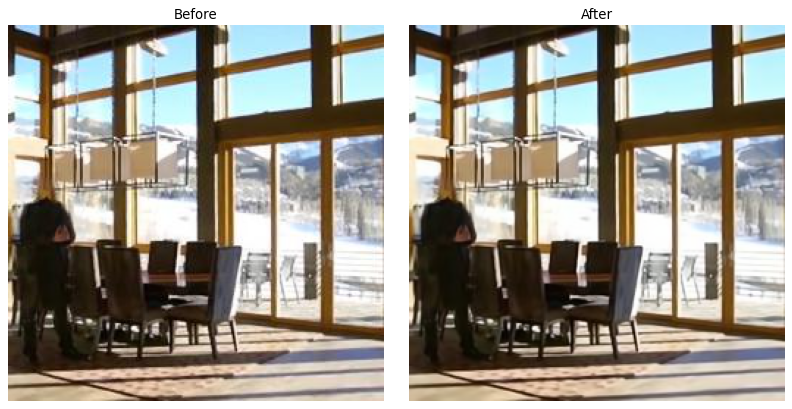

In [89]:
model = get_finetuned_instructIR_model()
image, restored_image = model.run("instructir/images/blurry_man.jpg")
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


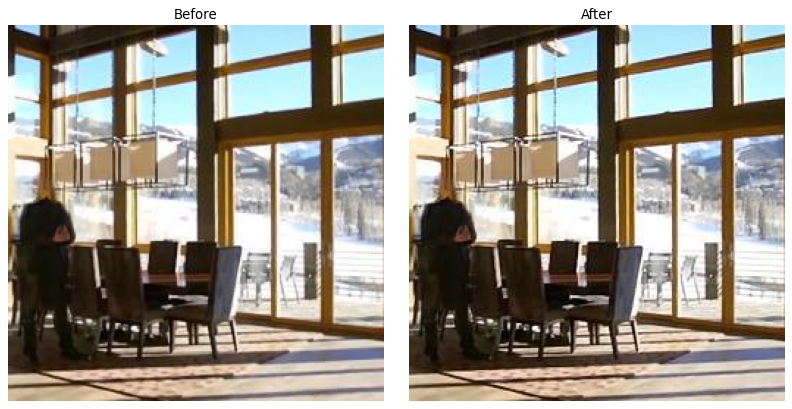

In [90]:
model = get_original_instructIR_model()
image, restored_image = model.run("instructir/images/blurry_man.jpg")
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

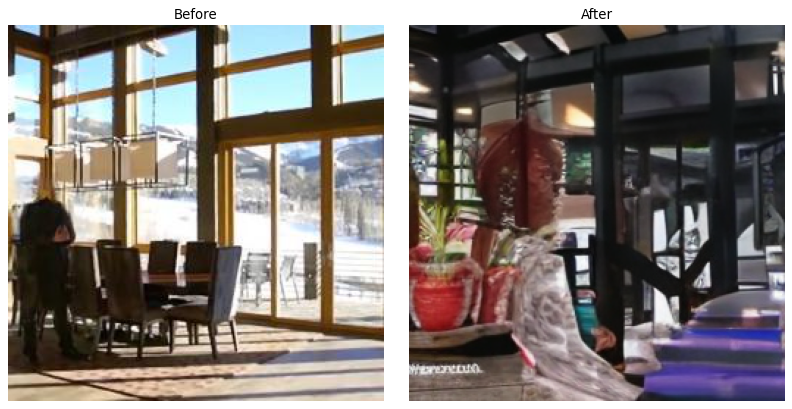

In [93]:
model = ControlNet()
# alternative for repo name is Wouter01/really_good_diffusion_model_out which has early checkpoints
# below is an early checkpoint so clearly garbage
image, restored_image = model.run("instructir/images/blurry_man.jpg",  repo_name="Wouter01/diffusion_re10k_hard", checkpoint="14000")
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))